In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [8]:
def model_basic(x_train, y_train, x_test, y_test):
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier(),
        
    ]

    rdict = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc_score': []}

    for clf in models:
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        pred_prob_rf = clf.predict_proba(x_test)[:, 1].reshape(-1, 1)
        auc_score = roc_auc_score(y_test, pred_prob_rf)
        results = (
            round(accuracy_score(y_test, pred), 4),
            round(precision_score(y_test, pred), 4),
            round(recall_score(y_test, pred), 4),
            round(f1_score(y_test, pred), 4),
            round(auc_score, 4)
        )

        rdict['model'].append(clf)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['auc_score'].append(results[4])

        confusion = confusion_matrix(y_test, pred)
        print(confusion)

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [9]:
train = pd.read_csv('./datasets/통계검증완료/코스닥_power_train.csv',index_col=0)
test =  pd.read_csv('./datasets/통계검증완료/코스닥_power_test.csv',index_col=0)



---
# 산업별 더미변수 - 제조업,건설업,정보통신업,그외
---

In [10]:
# train.loc[~(train['산업군'].str.contains('제조업') | train['산업군'].str.contains('건설업') | train['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(train['산업군'])
# train = pd.concat([train,dummy_df],axis=1)

In [11]:
# test.loc[~(test['산업군'].str.contains('제조업') | test['산업군'].str.contains('건설업') | test['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(test['산업군'])
# test = pd.concat([test,dummy_df],axis=1)

----

In [12]:
train.columns

Index(['회사명', '거래소코드', '회계년도', '산업군', 'EBIT/총자산', '총자본정상영업이익률', '현금흐름 대 자산',
       '현금흐름 대 매출액', '현금흐름/총부채비율', '차입금의존도', '자기자본순이익률', '부채비율', '총자본회전률',
       '누적수익성비율', 'EBITDA마진율', '자본금회전률', '순운전자본비율', '유형자산회전율', '영업현금흐름-단기차입금',
       '당기전기영업손익', '이자부담률', '시총/총자산', '총자본증가율', '금융비용부담률', 'FINDEP',
       'abs(영업현금흐름-당기순이익)/매출액', '부채상환계수', '자기자본증가율', '매출액총이익률', '매출액증가율',
       '외국인지분율', '대주주지분율', 'ROA변화율', '정상영업이익증가율', '유형자산증가율', 'target_1',
       'target_2', 'target_3'],
      dtype='object')

In [13]:
col_int = [ 'EBIT/총자산', '총자본정상영업이익률', '현금흐름 대 자산',
       '현금흐름 대 매출액', '현금흐름/총부채비율', '차입금의존도', '자기자본순이익률', '부채비율', '총자본회전률',
       '누적수익성비율', 'EBITDA마진율', '자본금회전률', '순운전자본비율', '유형자산회전율', '영업현금흐름-단기차입금',
       '당기전기영업손익', '이자부담률', '시총/총자산', '총자본증가율', '금융비용부담률', 'FINDEP',
       'abs(영업현금흐름-당기순이익)/매출액', '부채상환계수', '자기자본증가율', '매출액총이익률', '매출액증가율',
       '외국인지분율', '대주주지분율', 'ROA변화율', '정상영업이익증가율', '유형자산증가율']

---
#target1
---

In [14]:
x_train = train[col_int]
y_train = train[['target_1']]

x_test = test[col_int]
y_test = test[['target_1']]

In [15]:
y_test.value_counts()

target_1
0           3503
1             89
dtype: int64

In [16]:
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select.index = x_train.columns

---
# lasso - 임베디드기법
---

In [17]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select["lasso_0.1"] = selector.get_support()


---
# stepwise - 래퍼기법
---

In [18]:
# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.1)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_bwd'] = selector.get_support().tolist()

In [19]:
# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select['lda_bwd'] = selector.get_support().tolist()

---
## 비모수적 방법
---

In [20]:
# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_bwd'] = selector.get_support().tolist()

---
## 최종 select
---

In [43]:
for col in df_select.columns.to_list():
    df_select[col] = df_select[col].apply(lambda x : 1 if x==True else 0)
df_select['total'] = df_select.sum(axis=1)
df_select[df_select['total']>=5].index

Index(['EBIT/총자산', '자기자본순이익률', '누적수익성비율', '순운전자본비율', '당기전기영업손익', '시총/총자산',
       '총자본증가율', '매출액총이익률', '외국인지분율'],
      dtype='object')

In [22]:
최종_col =df_select[df_select['total']>=5].index.to_list()

x_train_1 = x_train[최종_col]
x_test_1 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

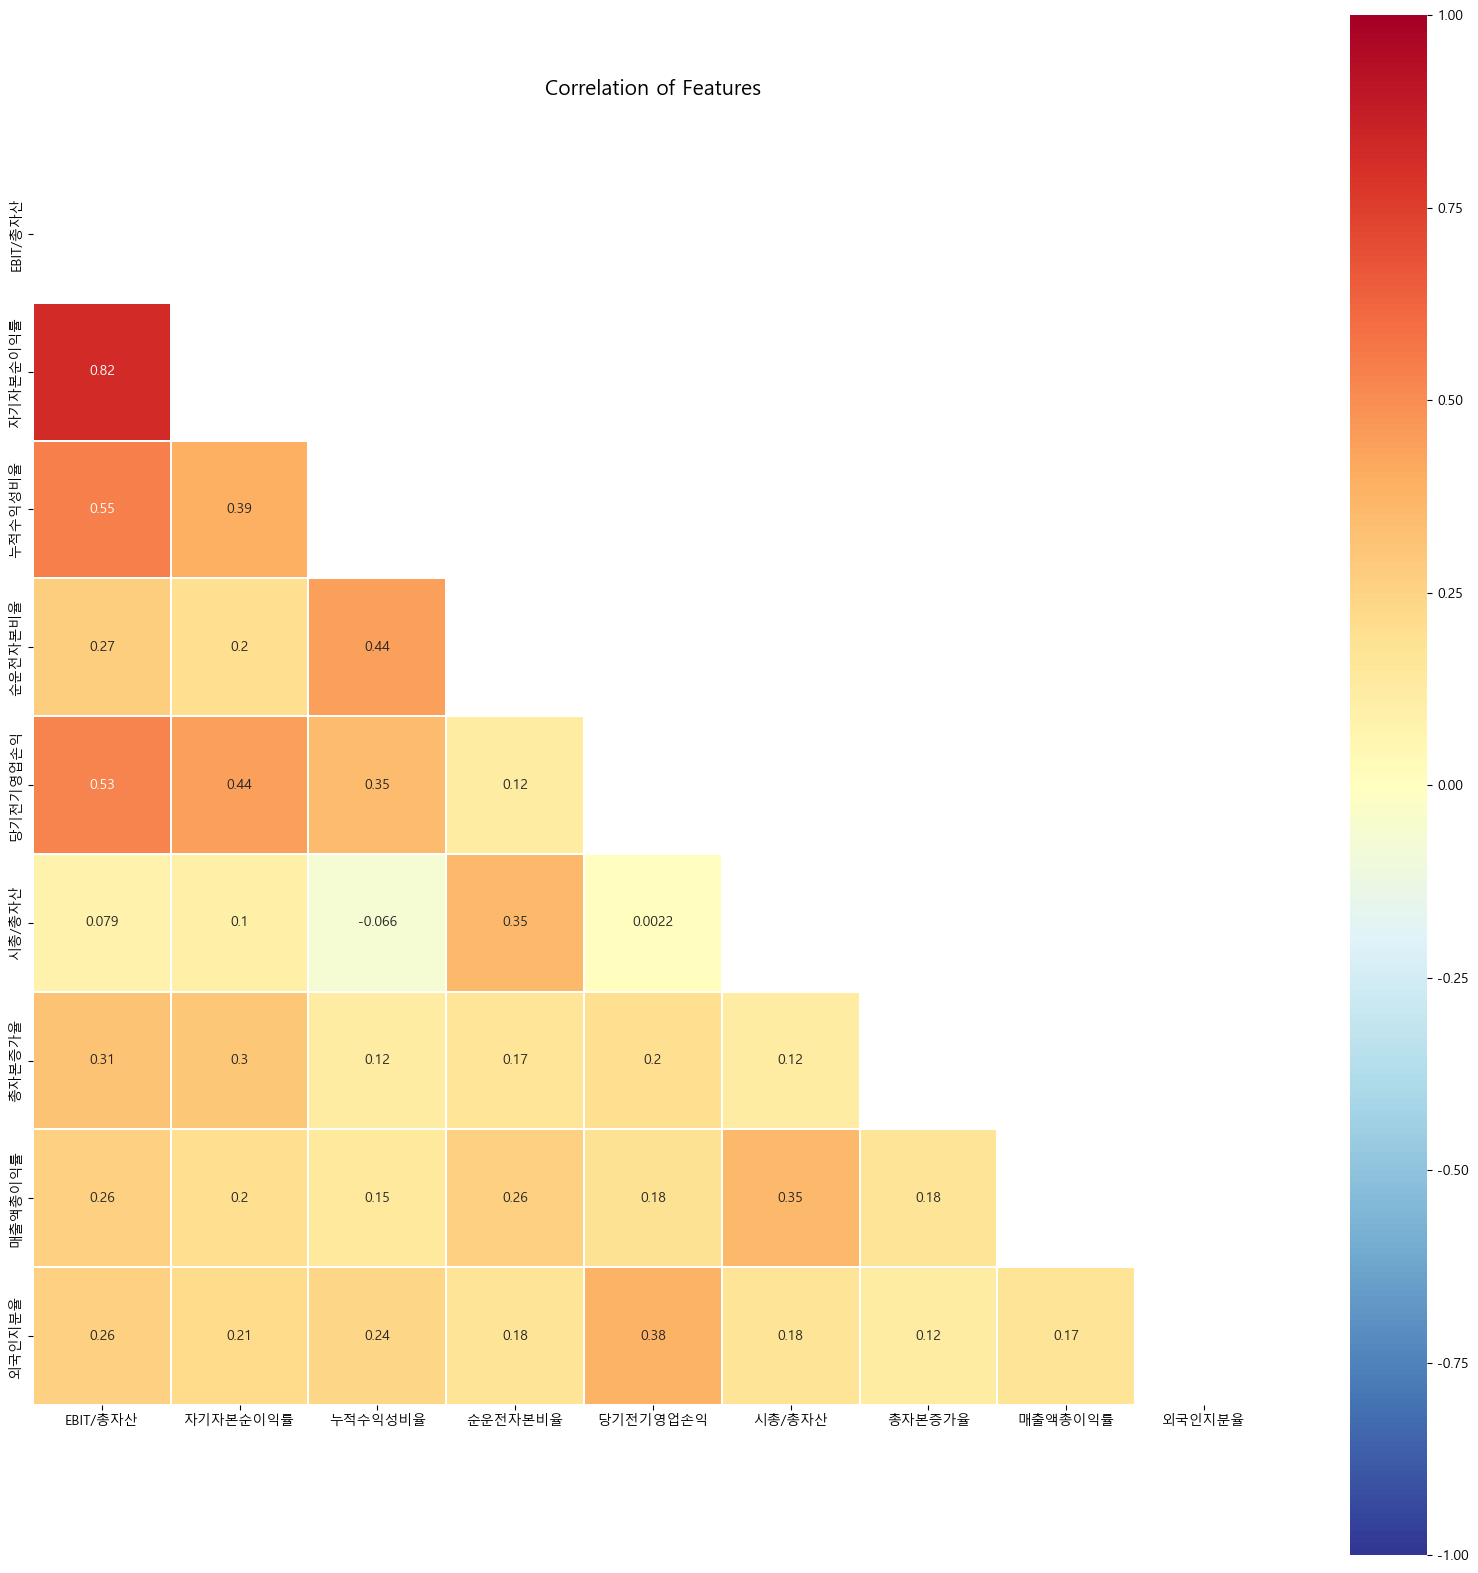

In [23]:
colormap = plt.cm.hot

corr = x_train_1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [24]:
model_basic(x_train_1,y_train,x_train_1,y_train)

[[5070   16]
 [ 115   59]]
[[5052   34]
 [ 109   65]]
[[4903  183]
 [  73  101]]
[[5086    0]
 [   0  174]]
[[5086    0]
 [   0  174]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9751,0.7867,0.3391,0.4739,0.9151
1,LinearDiscriminantAnalysis(),0.9728,0.6566,0.3736,0.4762,0.8862
2,GaussianNB(),0.9513,0.3556,0.5805,0.4410,0.9168
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [25]:
model_basic(x_train_1,y_train,x_test_1,y_test)

[[3467   36]
 [  52   37]]
[[3425   78]
 [  44   45]]
[[3126  377]
 [  28   61]]
[[3440   63]
 [  39   50]]
[[3454   49]
 [  51   38]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9755,0.5068,0.4157,0.4568,0.9188
1,LinearDiscriminantAnalysis(),0.9660,0.3659,0.5056,0.4245,0.8948
2,GaussianNB(),0.8872,0.1393,0.6854,0.2315,0.9162
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9716,0.4425,0.5618,0.4950,0.9281
4,"XGBClassifier(base_score=None, booster=None, c...",0.9722,0.4368,0.4270,0.4318,0.9300


-----
# target2

In [26]:
x_train = train[col_int]
y_train = train[['target_2']]

x_test = test[col_int]
y_test = test[['target_2']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_2 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_2.index = x_train.columns

In [27]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_2["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_2["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_2["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_2['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_bwd'] = selector.get_support().tolist()

In [45]:
for col in df_select_2.columns.to_list():
    df_select_2[col] = df_select_2[col].apply(lambda x : 1 if x==True else 0)
df_select_2['total'] = df_select_2.sum(axis=1)
df_select_2[df_select_2['total']>=5].index



Index(['EBIT/총자산', '자기자본순이익률', '누적수익성비율', '순운전자본비율', '당기전기영업손익', '이자부담률',
       '시총/총자산', '외국인지분율'],
      dtype='object')

In [29]:
최종_col =df_select_2[df_select_2['total']>=5].index.to_list()

x_train_2 = x_train[최종_col]
x_test_2 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

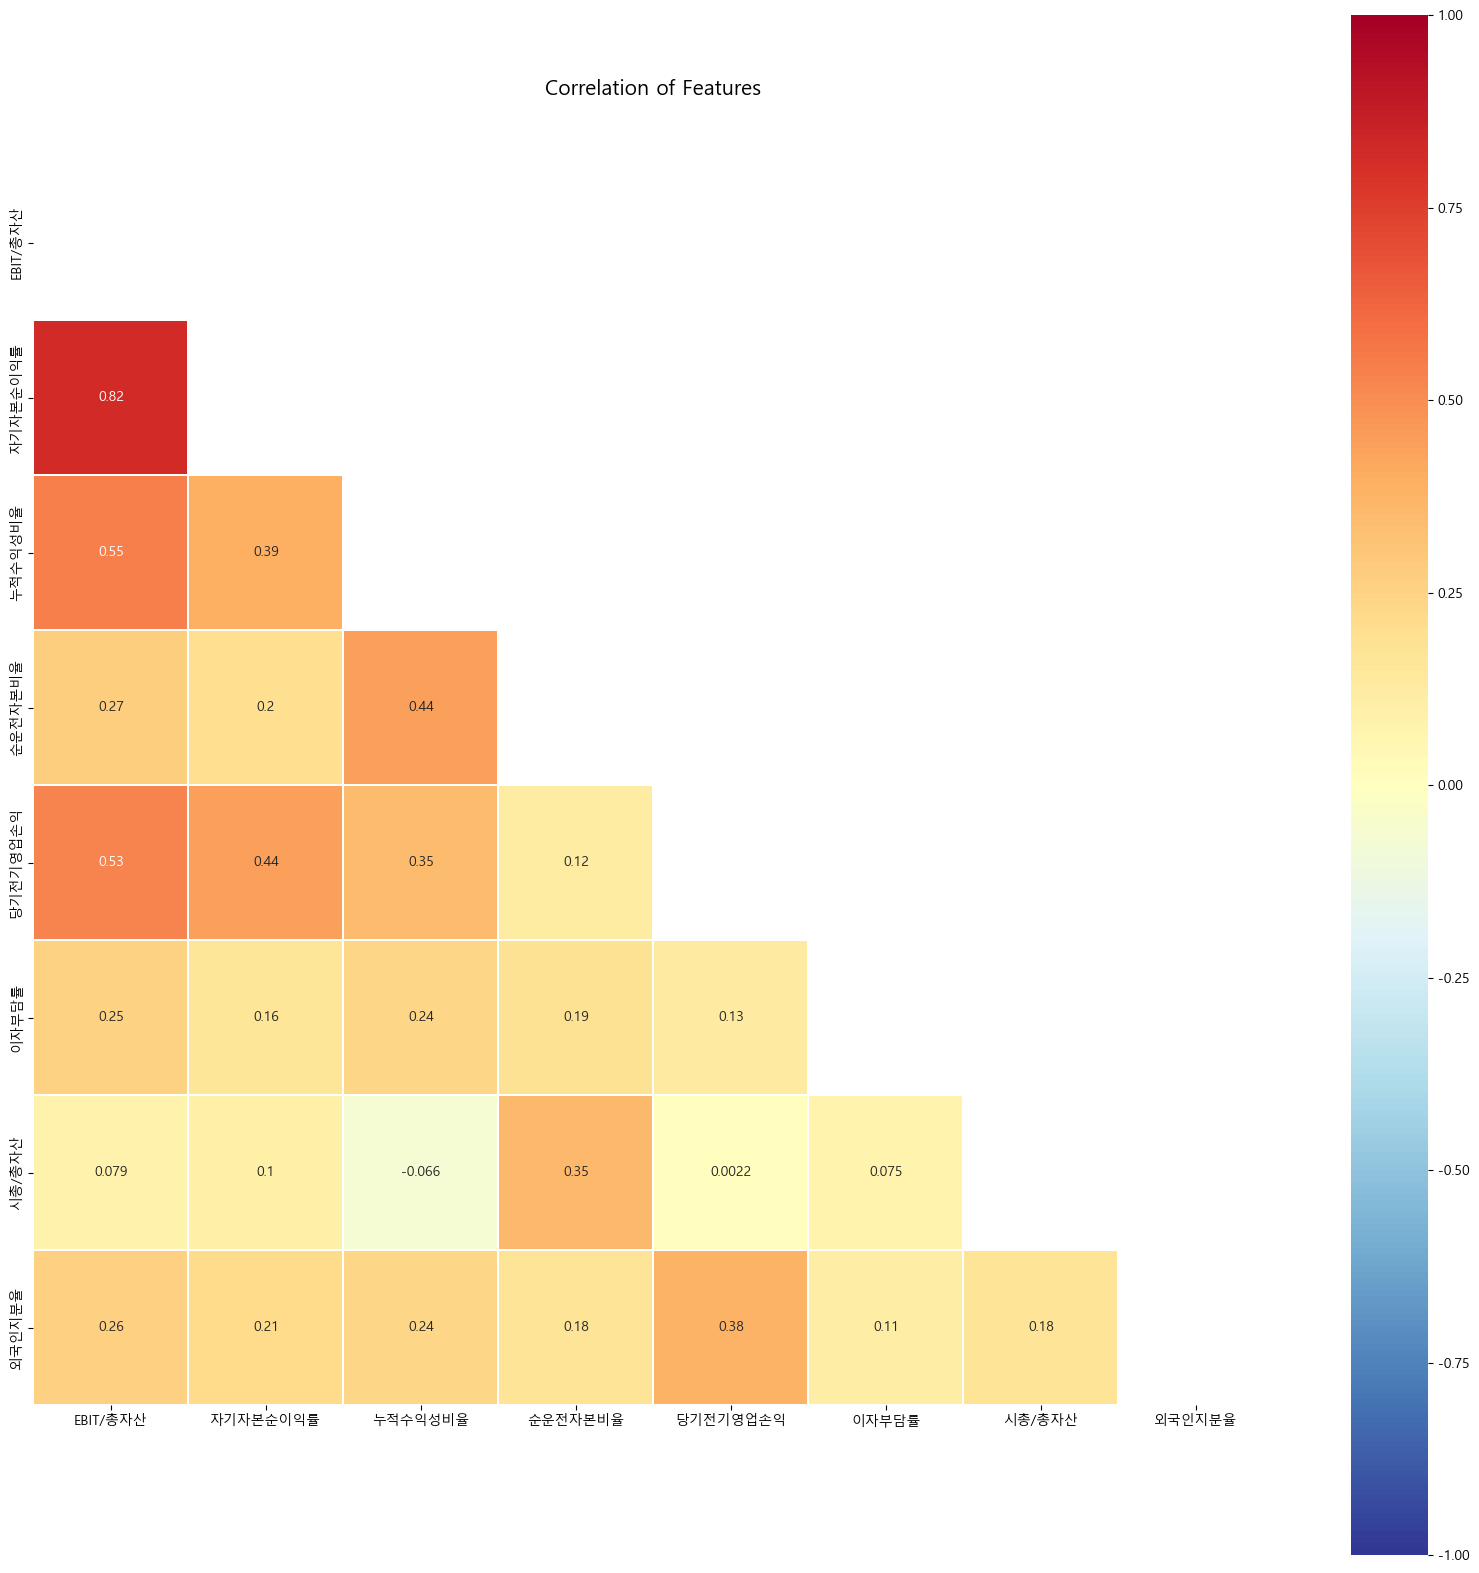

In [30]:
colormap = plt.cm.hot

corr = x_train_2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [31]:
model_basic(x_train_2,y_train,x_train_2,y_train)

[[5026   17]
 [ 155   62]]
[[5031   12]
 [ 169   48]]
[[4877  166]
 [ 122   95]]
[[5043    0]
 [   0  217]]
[[5043    0]
 [   0  217]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9673,0.7848,0.2857,0.4189,0.8970
1,LinearDiscriminantAnalysis(),0.9656,0.8000,0.2212,0.3466,0.8892
2,GaussianNB(),0.9452,0.3640,0.4378,0.3975,0.8848
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [32]:
model_basic(x_train_2,y_train,x_test_2,y_test)

[[3448   57]
 [  55   32]]
[[3455   50]
 [  56   31]]
[[3125  380]
 [  38   49]]
[[3455   50]
 [  49   38]]
[[3449   56]
 [  48   39]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9688,0.3596,0.3678,0.3636,0.8288
1,LinearDiscriminantAnalysis(),0.9705,0.3827,0.3563,0.3690,0.8206
2,GaussianNB(),0.8836,0.1142,0.5632,0.1899,0.8205
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9724,0.4318,0.4368,0.4343,0.8662
4,"XGBClassifier(base_score=None, booster=None, c...",0.9710,0.4105,0.4483,0.4286,0.8696


----
# target3

In [33]:
x_train = train[col_int]
y_train = train[['target_3']]

x_test = test[col_int]
y_test = test[['target_3']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_3 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_3.index = x_train.columns

In [34]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_3["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_3["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_3["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_3['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_bwd'] = selector.get_support().tolist()

In [35]:
for col in df_select_3.columns.to_list():
    df_select_3[col] = df_select_3[col].apply(lambda x : 1 if x==True else 0)
df_select_3['total'] = df_select_3.sum(axis=1)
df_select_3[df_select_3['total']>=5].index

Index(['EBIT/총자산', '자기자본순이익률', 'EBITDA마진율', '자본금회전률', '당기전기영업손익', '시총/총자산',
       '총자본증가율', '매출액증가율', 'ROA변화율'],
      dtype='object')

In [36]:
최종_col =df_select_3[df_select_3['total']>=5].index.to_list()

x_train_3 = x_train[최종_col]
x_test_3 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

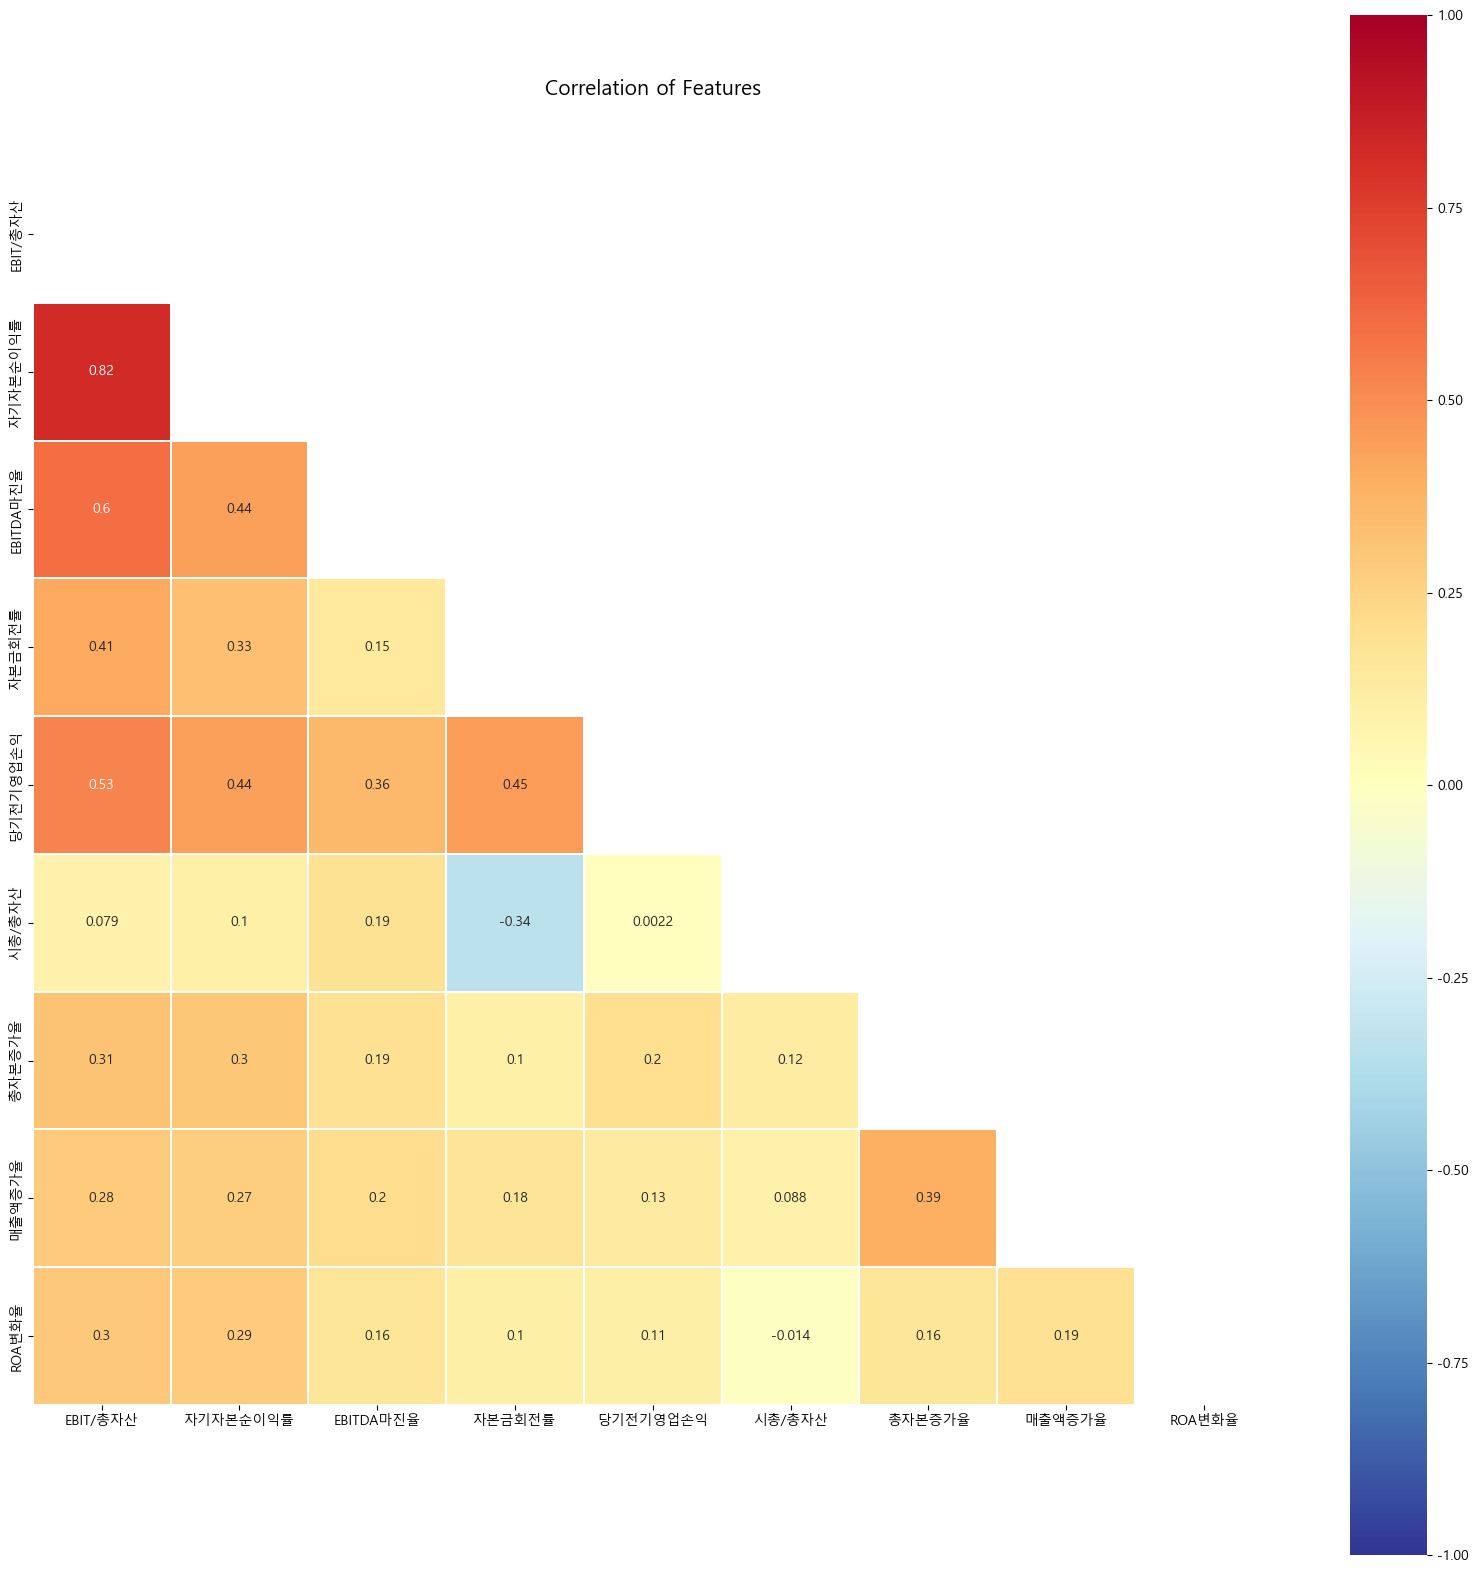

In [37]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [38]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[5083   12]
 [ 112   53]]
[[5060   35]
 [ 102   63]]
[[4832  263]
 [  72   93]]
[[5095    0]
 [   0  165]]
[[5095    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9764,0.8154,0.3212,0.4609,0.9154
1,LinearDiscriminantAnalysis(),0.9740,0.6429,0.3818,0.4791,0.8913
2,GaussianNB(),0.9363,0.2612,0.5636,0.3570,0.9001
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [39]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[3423   97]
 [  38   34]]
[[3374  146]
 [  32   40]]
[[3016  504]
 [  17   55]]
[[3454   66]
 [  34   38]]
[[3441   79]
 [  33   39]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9624,0.2595,0.4722,0.3350,0.8976
1,LinearDiscriminantAnalysis(),0.9504,0.2151,0.5556,0.3101,0.8986
2,GaussianNB(),0.8550,0.0984,0.7639,0.1743,0.8965
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9722,0.3654,0.5278,0.4318,0.9181
4,"XGBClassifier(base_score=None, booster=None, c...",0.9688,0.3305,0.5417,0.4105,0.9116
